## Data Cleaning

In [543]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import coint
import warnings
warnings.filterwarnings('ignore')

# Load transit time data from all three sheets
xl_file = 'data/colonial_transit_time.xlsx'

# Read data from each sheet
line1_data = pd.read_excel(xl_file, sheet_name='line1')
line3_data = pd.read_excel(xl_file, sheet_name='line3') 
line13_data = pd.read_excel(xl_file, sheet_name='line13')

print("Data loaded successfully:")
print(f"Line 1: {len(line1_data)} records")
print(f"Line 3: {len(line3_data)} records") 
print(f"Line 13: {len(line13_data)} records")

# Display first few rows of each dataset
print("\n=== Line 1 Data Sample ===")
display(line1_data.head())
print(f"Columns: {line1_data.columns.tolist()}")

print("\n=== Line 3 Data Sample ===")
display(line3_data.head())
print(f"Columns: {line3_data.columns.tolist()}")

print("\n=== Line 13 Data Sample ===") 
display(line13_data.head())
print(f"Columns: {line13_data.columns.tolist()}")

Data loaded successfully:
Line 1: 78 records
Line 3: 48 records
Line 13: 373 records

=== Line 1 Data Sample ===


,Date,From,To,Cycle,Gas Days,Gas Hours,Distillates Days,Distillates Hours,Gas Transit Days
0,2024-08-22,HTN,GBJ,46,8,7,7,7,8.291667
1,2024-08-26,HTN,GBJ,47,7,6,7,10,7.250000
2,2024-08-29,HTN,GBJ,48,8,18,9,10,8.750000
3,2024-09-04,HTN,GBJ,49,7,6,9,10,7.250000
4,2024-09-08,HTN,GBJ,50,8,23,9,18,8.958333


Columns: ['Date', 'From', 'To', 'Cycle', 'Gas Days', 'Gas Hours', 'Distillates Days', 'Distillates Hours', 'Gas Transit Days']

=== Line 3 Data Sample ===


,Date,From,To,Cycle,Gas Days,Gas Hours,Distillates Days,Distillates Hours,Gas Transit Days
0,2025-01-15,GBJ,HTN,3,7.0,17.0,3.0,11.0,7.708333
1,2025-01-21,GBJ,HTN,4,8.0,6.0,3.0,4.0,8.250000
2,2025-01-26,GBJ,HTN,5,8.0,5.0,NaN,NaN,8.208333
3,2025-02-02,GBJ,HTN,6,7.0,3.0,3.0,5.0,7.125000
4,2025-02-05,GBJ,HTN,7,5.0,8.0,2.0,18.0,5.333333


Columns: ['Date', 'From', 'To', 'Cycle', 'Gas Days', 'Gas Hours', 'Distillates Days', 'Distillates Hours', 'Gas Transit Days']

=== Line 13 Data Sample ===


,Date,From,To,Cycle,Gas Days,Gas Hours,Distillates Days,Distillates Hours,Gas Transit Days
0,2020-07-01,HTN,LNJ,38,18,8,NaN,NaN,18.333333
1,2020-07-01,HTN,LNJ,39,18,5,NaN,NaN,18.208333
2,2020-07-01,HTN,LNJ,40,17,5,NaN,NaN,17.208333
3,2020-07-01,HTN,LNJ,41,17,22,NaN,NaN,17.916667
4,2020-07-01,HTN,LNJ,42,20,5,NaN,NaN,20.208333


Columns: ['Date', 'From', 'To', 'Cycle', 'Gas Days', 'Gas Hours', 'Distillates Days', 'Distillates Hours', 'Gas Transit Days']


## Step 1: Calculate Gas Transit Days

Converting the separate Gas Days and Gas Hours columns into a single decimal Gas Transit Days column for Line 1 and Line 3 data to match the Line 13 format. This will enable direct comparison across all three pipeline lines.

In [544]:
# Create Gas Transit Days column for Line 1 and Line 3 (similar to Line 13)
# Convert Gas Days + Gas Hours to decimal days
line1_data['Gas Transit Days'] = line1_data['Gas Days'] + line1_data['Gas Hours'] / 24
line3_data['Gas Transit Days'] = line3_data['Gas Days'] + line3_data['Gas Hours'] / 24

# Add year column for consistency
line1_data['Date'] = pd.to_datetime(line1_data['Date'])
line3_data['Date'] = pd.to_datetime(line3_data['Date'])
line13_data['Date'] = pd.to_datetime(line13_data['Date'])

line1_data['year'] = line1_data['Date'].dt.year
line3_data['year'] = line3_data['Date'].dt.year

print("Gas Transit Days calculated:")
display(line1_data['Gas Transit Days'].describe())
display(line3_data['Gas Transit Days'].describe())
display(line13_data['Gas Transit Days'].describe())

# Display sample with new column
print("\n=== Line 1 with Gas Transit Days ===")
display(line1_data[['Date', 'Gas Days', 'Gas Hours', 'Gas Transit Days', 'year']].head())

print("\n=== Line 3 with Gas Transit Days ===")
display(line3_data[['Date', 'Gas Days', 'Gas Hours', 'Gas Transit Days', 'year']].head())

Gas Transit Days calculated:


count    78.000000
mean      8.432692
std       0.803476
min       7.208333
25%       7.718750
50%       8.333333
75%       9.031250
max      11.250000
Name: Gas Transit Days, dtype: float64

count    47.000000
mean      5.178191
std       2.225319
min       0.333333
25%       3.979167
50%       5.041667
75%       6.604167
max      10.458333
Name: Gas Transit Days, dtype: float64

count    373.000000
mean      16.582440
std        4.073592
min        9.583333
25%       14.041667
50%       15.666667
75%       18.666667
max       38.125000
Name: Gas Transit Days, dtype: float64


=== Line 1 with Gas Transit Days ===


,Date,Gas Days,Gas Hours,Gas Transit Days,year
0,2024-08-22,8,7,8.291667,2024
1,2024-08-26,7,6,7.250000,2024
2,2024-08-29,8,18,8.750000,2024
3,2024-09-04,7,6,7.250000,2024
4,2024-09-08,8,23,8.958333,2024



=== Line 3 with Gas Transit Days ===


,Date,Gas Days,Gas Hours,Gas Transit Days,year
0,2025-01-15,7.0,17.0,7.708333,2025
1,2025-01-21,8.0,6.0,8.250000,2025
2,2025-01-26,8.0,5.0,8.208333,2025
3,2025-02-02,7.0,3.0,7.125000,2025
4,2025-02-05,5.0,8.0,5.333333,2025


## Step 2: Find Overlapping Time Periods

Identifying the common date range between Line 1 and Line 3 data to enable correlation analysis. This ensures we're comparing transit times from the same time periods.

In [545]:
# Correlation Analysis between different lines
# First, let's find overlapping time periods for correlation analysis

# Get date ranges for each dataset
print("Date Ranges:")
print(f"Line 1: {line1_data['Date'].min()} to {line1_data['Date'].max()}")
print(f"Line 3: {line3_data['Date'].min()} to {line3_data['Date'].max()}")
print(f"Line 13: {line13_data['Date'].min()} to {line13_data['Date'].max()}")

# Find common date range for Line 1 and Line 3 (most recent data)
line1_line3_start = max(line1_data['Date'].min(), line3_data['Date'].min())
line1_line3_end = min(line1_data['Date'].max(), line3_data['Date'].max())

print(f"\nOverlapping period for Line 1 & Line 3: {line1_line3_start} to {line1_line3_end}")

# Filter data for overlapping period
line1_overlap = line1_data[(line1_data['Date'] >= line1_line3_start) & (line1_data['Date'] <= line1_line3_end)].copy()
line3_overlap = line3_data[(line3_data['Date'] >= line1_line3_start) & (line3_data['Date'] <= line1_line3_end)].copy()

print(f"Overlapping records: Line 1={len(line1_overlap)}, Line 3={len(line3_overlap)}")

Date Ranges:
Line 1: 2024-08-22 00:00:00 to 2025-09-02 00:00:00
Line 3: 2025-01-15 00:00:00 to 2025-09-02 00:00:00
Line 13: 2020-07-01 00:00:00 to 2025-09-02 00:00:00

Overlapping period for Line 1 & Line 3: 2025-01-15 00:00:00 to 2025-09-02 00:00:00
Overlapping records: Line 1=48, Line 3=48


## Results Summary

The refactored analysis now tests **all possible combinations** of pipeline lines:

- **Line 1 vs Line 3**: Recent data (2024-2025) covering both directions (HTN <-> GBJ)
- **Line 1 vs Line 13**: Cross-check with the historical HTN <-> LNJ path
- **Line 3 vs Line 13**: Reverse-flow validation for GBJ <-> HTN versus HTN <-> LNJ



### Merged Pipeline Data & Cointegration Inputs

The merged dataset simply stores the three pipeline DataFrames in a single dictionary so the helper modules can access them consistently.


In [546]:
from line1_implied.correlation import analyze_correlation_pair, print_correlation_results

# Analyze all possible pairs
pipeline_data = {
    'Line1': line1_data,
    'Line3': line3_data,
    'Line13': line13_data,
}

pairs = [
    ('Line1', 'Line3'),
    ('Line1', 'Line13'),
    ('Line3', 'Line13'),
]

correlation_results = {}
for name1, name2 in pairs:
    results = analyze_correlation_pair(
        pipeline_data[name1],
        pipeline_data[name2],
        name1,
        name2,
    )
    correlation_results[f"{name1}_vs_{name2}"] = results
    print_correlation_results(results)



ANALYSIS: Line1 vs Line3
Period: 2025-01-15 to 2025-09-02
Total paired observations: 48
Clean observations (no NaN): 47

Correlation Results:
  • Pearson:  r = 0.1003 (p = 0.5024)
  • Spearman: ρ = 0.0713 (p = 0.6337)
  • Relationship: Weak positive correlation

Cointegration Test:
  • ADF Statistic: -2.7414
  • P-value: 0.1850
  • Result: ❌ Not cointegrated

ANALYSIS: Line1 vs Line13
Period: 2024-08-22 to 2025-09-02
Total paired observations: 54
Clean observations (no NaN): 54

Correlation Results:
  • Pearson:  r = 0.6165 (p = 0.0000)
  • Spearman: ρ = 0.5856 (p = 0.0000)
  • Relationship: Moderate positive correlation

Cointegration Test:
  • ADF Statistic: -4.5548
  • P-value: 0.0010
  • Result: 🎯 COINTEGRATED (long-term equilibrium exists)

ANALYSIS: Line3 vs Line13
Period: 2025-01-15 to 2025-09-02
Total paired observations: 48
Clean observations (no NaN): 47

Correlation Results:
  • Pearson:  r = 0.7028 (p = 0.0000)
  • Spearman: ρ = 0.6591 (p = 0.0000)
  • Relationship: Strong

### Test Assumptions

Stationarity diagnostics confirm the series satisfy the ECM prerequisites.


In [547]:
from line1_implied.stationarity import analyze_pipeline_stationarity

stationarity_results = analyze_pipeline_stationarity(pipeline_data)


🔍 STATIONARITY ANALYSIS FOR ALL PIPELINES

STATIONARITY ANALYSIS: Line1 Transit Days
Data Summary:
  • Observations: 78
  • Mean: 8.4327
  • Std Dev: 0.8035
  • Range: [7.2083, 11.2500]

🔍 Augmented Dickey-Fuller Test:
  • Test Statistic: -2.861060
  • P-value: 0.050067
  • Lags Used: 1
  • Critical Values:
    - 1%: -3.519481
    - 5%: -2.900395
    - 10%: -2.587498
  • Conclusion: Non-stationary (p ≥ 0.05)

📊 KPSS Test:
  • Test Statistic: 0.848245
  • P-value: 0.010000
  • Lags Used: 4
  • Critical Values:
    - 10%%: 0.347000
    - 5%%: 0.463000
    - 2.5%%: 0.574000
    - 1%%: 0.739000
  • Conclusion: Non-stationary (p ≤ 0.05)

🎯 OVERALL CONCLUSION: NON-STATIONARY (both tests agree)

STATIONARITY ANALYSIS: Line3 Transit Days
Data Summary:
  • Observations: 47
  • Mean: 5.1782
  • Std Dev: 2.2253
  • Range: [0.3333, 10.4583]

🔍 Augmented Dickey-Fuller Test:
  • Test Statistic: -4.869395
  • P-value: 0.000040
  • Lags Used: 0
  • Critical Values:
    - 1%: -3.581258
    - 5%: -2.926

## Pairwise Diagnostics

Matrix of time-series, distributions, scatter relationships, and overlap plots for each pipeline pair.


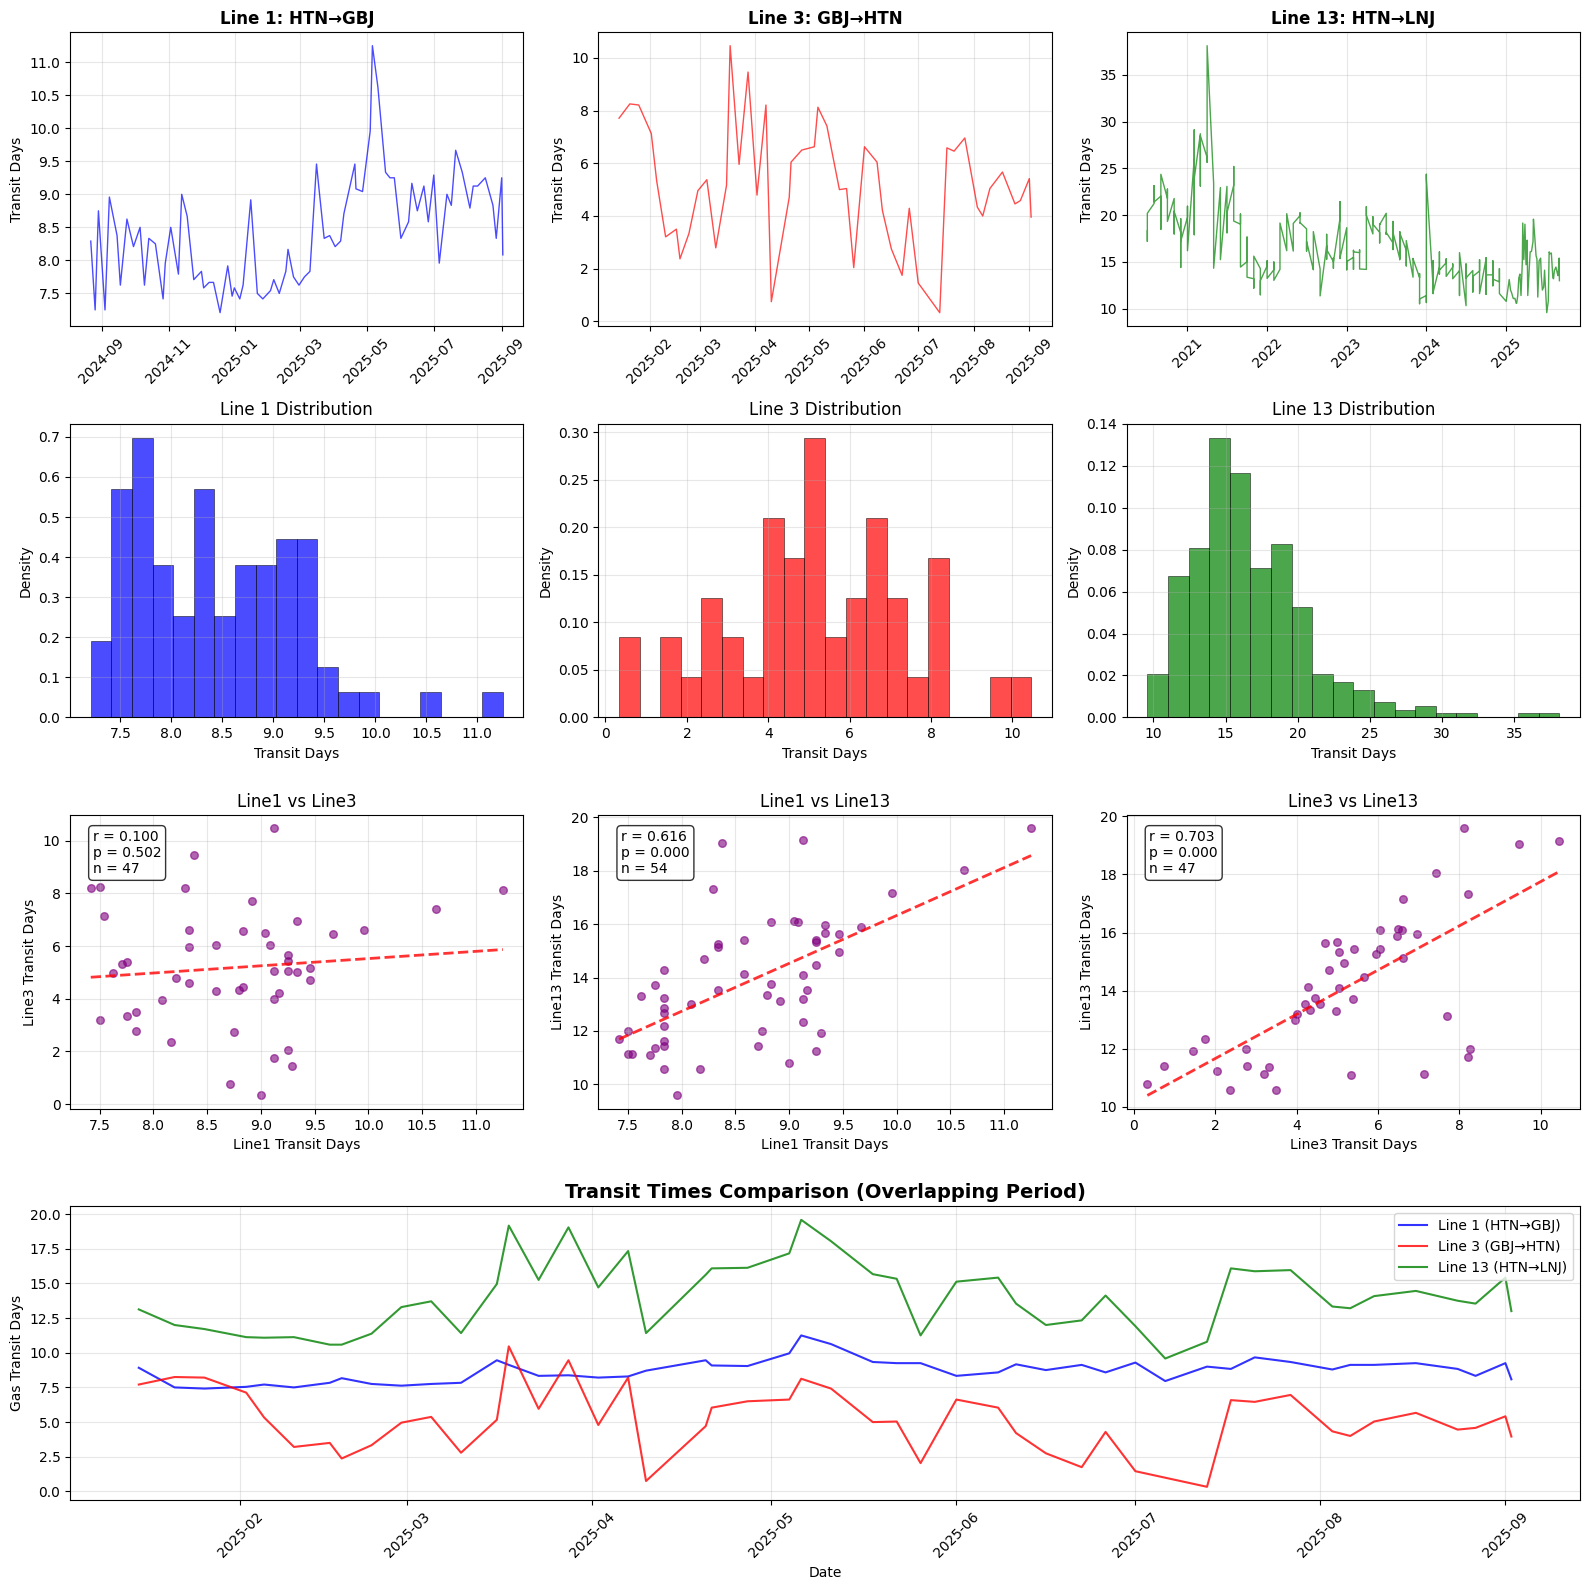


📊 Transit Time Correlation Matrix Analysis Complete!

This visualization shows:
• Row 1: Individual time series for each pipeline line
• Row 2: Distribution histograms showing transit time patterns
• Row 3: Scatter plots with regression lines for all pair combinations
• Row 4: Overlay plot showing all lines during their common time period


In [548]:
from line1_implied.correlation import create_transit_correlation_matrix

# Create the comprehensive transit correlation matrix with robust error handling

correlation_matrix_fig = create_transit_correlation_matrix(correlation_results, pipeline_data)
print("\n📊 Transit Time Correlation Matrix Analysis Complete!")
print("\nThis visualization shows:")
print("• Row 1: Individual time series for each pipeline line")
print("• Row 2: Distribution histograms showing transit time patterns")  
print("• Row 3: Scatter plots with regression lines for all pair combinations")
print("• Row 4: Overlay plot showing all lines during their common time period")


In [549]:
from line1_implied.correlation import create_summary_table, create_stats_table

# Generate the summary tables
print("\n" + "="*80)
print("COMPREHENSIVE CORRELATION SUMMARY")
print("="*80)

summary_df = create_summary_table(correlation_results)
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("TRANSIT TIME STATISTICS BY LINE") 
print("="*80)

stats_df = create_stats_table(pipeline_data)
print(stats_df.to_string(index=False))

# Additional insights
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

# Count significant correlations
significant_correlations = 0
total_correlations = 0

for key, results in correlation_results.items():
    if 'pearson_p' in results and not pd.isna(results['pearson_p']):
        total_correlations += 1
        if results['pearson_p'] < 0.05:
            significant_correlations += 1

print(f"• Total correlation pairs analyzed: {len(correlation_results)}")
print(f"• Pairs with valid correlations: {total_correlations}")
print(f"• Statistically significant correlations (p < 0.05): {significant_correlations}")

# Identify strongest correlations
valid_correlations = []
for key, results in correlation_results.items():
    if 'pearson_r' in results and not pd.isna(results['pearson_r']):
        valid_correlations.append((key, abs(results['pearson_r']), results['pearson_r']))

if valid_correlations:
    strongest = max(valid_correlations, key=lambda x: x[1])
    print(f"• Strongest correlation: {strongest[0]} (r = {strongest[2]:.3f})")

# Cointegration summary
cointegrated_pairs = [key for key, results in correlation_results.items() 
                     if results.get('is_cointegrated', False)]
if cointegrated_pairs:
    print(f"• Cointegrated pairs: {len(cointegrated_pairs)} ({', '.join(cointegrated_pairs)})")
else:
    print("• No cointegrated pairs detected")


COMPREHENSIVE CORRELATION SUMMARY
           Pair                   Period  N Pearson r P-value Spearman ρ Cointegrated Coint p-value
 Line1 vs Line3 2025-01-15 to 2025-09-02 48     0.100   0.502      0.071            ❌         0.185
Line1 vs Line13 2024-08-22 to 2025-09-02 54     0.616   0.000      0.586            ✅         0.000
Line3 vs Line13 2025-01-15 to 2025-09-02 48     0.703   0.000      0.659            ❌         0.061

TRANSIT TIME STATISTICS BY LINE
  Line     Route  Records Mean (days) Std (days) Min (days) Max (days)               Date Range
 Line1 HTN → GBJ       78        8.43       0.80       7.21      11.25 2024-08-22 to 2025-09-02
 Line3 GBJ → HTN       47        5.18       2.23       0.33      10.46 2025-01-15 to 2025-09-02
Line13 HTN → LNJ      373       16.58       4.07       9.58      38.12 2020-07-01 to 2025-09-02

KEY INSIGHTS
• Total correlation pairs analyzed: 3
• Pairs with valid correlations: 3
• Statistically significant correlations (p < 0.05): 2
• Stro

## Data Preparation for ECM Forecasting

Prepare aligned time series data from `pipeline_data` so the ECM helpers receive a clean common-sample dataset with a trend column.


In [550]:
from line1_implied.preparation import _prepare_aligned_data

# Execute the data preparation function
print("🚀 Executing _prepare_aligned_data() function...")
aligned_data = _prepare_aligned_data(pipeline_data, correlation_results)

# Display the prepared dataset
if aligned_data is not None:
    print(f"\n📋 First 10 rows of aligned dataset:")
    display(aligned_data.head(10))
    
    print(f"\n📋 Last 5 rows of aligned dataset:")
    display(aligned_data.tail(5))
    
    print(f"\n💾 Aligned dataset ready for ECM forecasting!")
    print(f"Variable name: 'aligned_data'")
    print(f"Shape: {aligned_data.shape}")
    print(f"Columns: {list(aligned_data.columns)}")
    print(f"Available for downstream ECM modeling...")
else:
    print("❌ Data preparation failed. Please check the pipeline_data structure.")

🚀 Executing _prepare_aligned_data() function...
🔄 Preparing aligned data for ECM forecasting...
✅ Line1: 78 clean records (2024-08-22 to 2025-09-02)
✅ Line3: 47 clean records (2025-01-15 to 2025-09-02)
✅ Line13: 373 clean records (2020-07-01 to 2025-09-02)

📊 Data extraction summary:
  • Line1: 78/78 records, mean transit = 8.43 days
  • Line3: 47/48 records, mean transit = 5.18 days
  • Line13: 373/373 records, mean transit = 16.58 days

🔗 Common period analysis:
  • Line1 dates: 78
  • Line3 dates: 47
  • Line13 dates: 103
  • Common dates: 47
  • Common period: 2025-01-15 to 2025-09-02

📋 Final dataset validation:
  • Final dataset shape: (47, 5)
  • Columns: ['Date', 'L1', 'L3', 'L13', 'trend']
  • Date range: 2025-01-15 to 2025-09-02
  • Complete observations (no missing values): 47
  • L1: std=0.814, unique_values=32
  • L3: std=2.225, unique_values=43
  • L13: std=2.411, unique_values=40

📊 Summary statistics (common period only):
           L1      L3     L13
count  47.000  47.

,Date,L1,L3,L13,trend
0,2025-01-15,8.916667,7.708333,13.125000,1
1,2025-01-21,7.500000,8.250000,12.000000,2
2,2025-01-26,7.416667,8.208333,11.708333,3
3,2025-02-02,7.541667,7.125000,11.125000,4
4,2025-02-05,7.708333,5.333333,11.083333,5
5,2025-02-10,7.500000,3.208333,11.125000,6
6,2025-02-16,7.833333,3.500000,10.583333,7
7,2025-02-18,8.166667,2.375000,10.583333,8
8,2025-02-23,7.750000,3.333333,11.375000,9
9,2025-02-28,7.625000,4.958333,13.291667,10



📋 Last 5 rows of aligned dataset:


,Date,L1,L3,L13,trend
42,2025-08-17,9.250000,5.666667,14.458333,43
43,2025-08-24,8.833333,4.458333,13.750000,44
44,2025-08-27,8.333333,4.583333,13.541667,45
45,2025-09-01,9.250000,5.416667,15.416667,46
46,2025-09-02,8.083333,3.958333,13.000000,47



💾 Aligned dataset ready for ECM forecasting!
Variable name: 'aligned_data'
Shape: (47, 5)
Columns: ['Date', 'L1', 'L3', 'L13', 'trend']
Available for downstream ECM modeling...


## Cointegrating Relationship Estimation

Use `line1_implied.cointegration._estimate_cointegrating_relation` to fit the long-run equation (L1_t = beta0 + beta1 * L13_t + beta2 * trend_t + u_t) and capture the error-correction term plus diagnostics.


In [551]:
from line1_implied.cointegration import _estimate_cointegrating_relation

🚀 Executing _estimate_cointegrating_relation() function with aligned_data...

🔍 Estimating Long-Run Cointegrating Relationship
Model: L1_t = β0 + β1*L13_t + β2*trend_t + u_t

📊 Data Summary:
   • Observations: 47
   • L1 range: [7.42, 11.25] days
   • L13 range: [10.58, 19.58] days
   • Trend range: [1, 47]

📈 Model Estimation Results:
----------------------------------------
   L1_t = 5.7113 + 0.1775*L13_t + 0.0220*trend_t + u_t

📊 Coefficient Estimates:
   • β0 (Intercept): 5.7113 ± 0.5195
     - t-stat: 10.994, p-value: 0.0000
   • β1 (L13 coefficient): 0.1775 ± 0.0370
     - t-stat: 4.799, p-value: 0.0000
   • β2 (Trend coefficient): 0.0220 ± 0.0065
     - t-stat: 3.390, p-value: 0.0015

💡 Economic Interpretation:
----------------------------------------
   • L13 Effect: 1-day increase in L13 transit time increases L1 by 0.177 days
     (Statistically significant at 5% level)
   • Time Trend: upward trend of 0.0220 days per period
     (Approximately 8.05 days per year)

🔬 Model Di

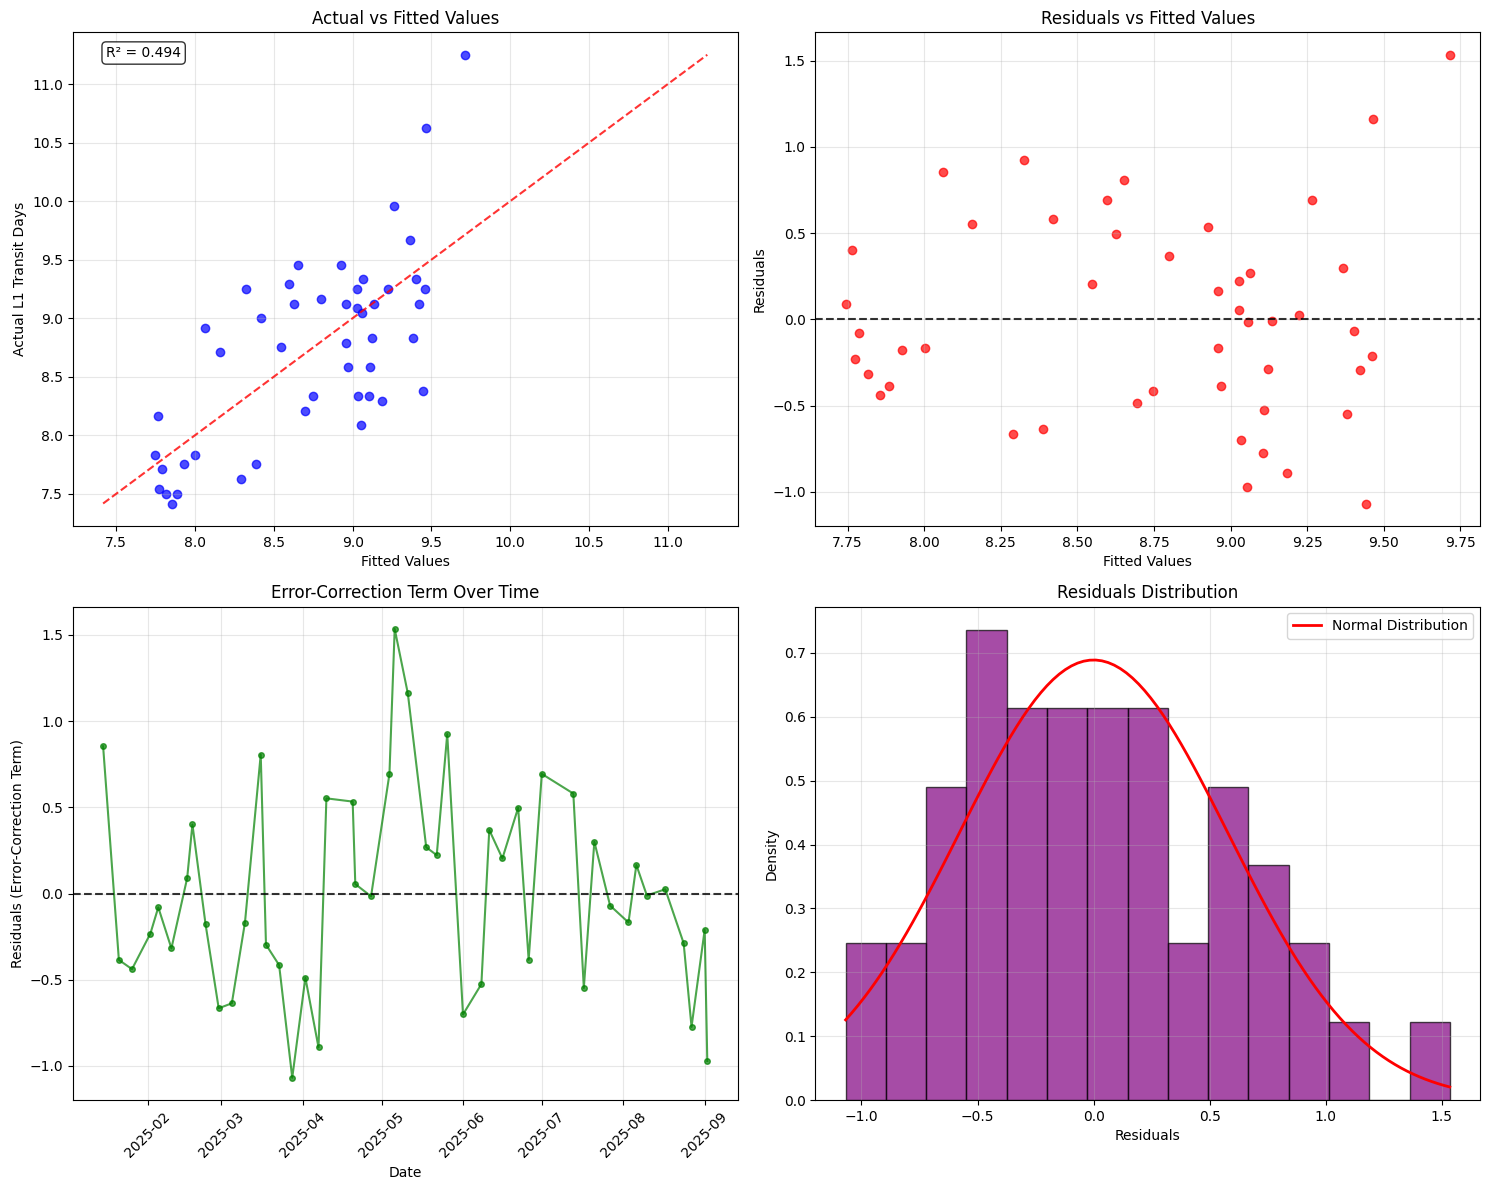

🔬 Residual Diagnostics:
----------------------------------------
   • Shapiro-Wilk normality test: W = 0.9844, p = 0.7756
     Residuals appear normally distributed ✅
   • Residual mean: 0.000000 (should be ≈ 0)
   • Residual std: 0.5791
   • Min residual: -1.0682
   • Max residual: 1.5343

✅ Cointegrating relationship estimation complete!
📋 Error-correction term (u_t) extracted for ECM modeling
📊 Model explains 49.4% of L1 transit time variation

💾 Results stored in variables:
   • cointegration_results: Complete model results dictionary
   • error_correction_term: Residuals (u_t) for ECM modeling

📋 Ready for the next step: ECM model specification and estimation!


In [552]:
# Execute the cointegrating relationship estimation
print("🚀 Executing _estimate_cointegrating_relation() function with aligned_data...")
print()

# Estimate the cointegrating relationship: L1_t = β0 + β1*L13_t + β2*trend_t + u_t
cointegration_results = _estimate_cointegrating_relation(aligned_data)

# Store the error-correction term for ECM modeling
error_correction_term = cointegration_results['residuals']

print()
print("💾 Results stored in variables:")
print("   • cointegration_results: Complete model results dictionary")
print("   • error_correction_term: Residuals (u_t) for ECM modeling")
print()
print("📋 Ready for the next step: ECM model specification and estimation!")

## ECM Model Implementation

Call `line1_implied.ecm._build_ecm_model` to select lags, estimate the short-run dynamics with HAC covariance, and run residual diagnostics.


In [553]:
from line1_implied.ecm import _build_ecm_model

## Run ECM Model

Execute `_build_ecm_model` with the aligned data and cointegration outputs to produce the fitted ECM and validation statistics.


In [554]:
ecm_results = _build_ecm_model(
    aligned_data=aligned_data,
    cointegration_results=cointegration_results,
    allow_contemporaneous=False,  # force q,r ≥ 1 so h=1 uses info known at t
    ic_kind="BIC",                # or "AICc"
    include_L3=True,              # keep ΔL3 in short run; set False to test without
    max_lags_cap=3                # small & stable for T≈40
)


🔧 BUILDING ERROR CORRECTION MODEL (ECM)
📈 Step 1: Index Alignment & First Differences
----------------------------------------
   ✅ Created differences: 46 observations
   ✅ Error correction term u_{t-1} aligned: 46 observations
Step 2: Data Validation
----------------------------------------
   dL1 std: 0.627228
   dL13 std: 2.395508
   dL3 std: 2.611184
⚙️  Step 3: HAC Covariance Configuration
----------------------------------------
   📊 Auto-computed HAC maxlags: 3 (based on T=46)
🔍 Step 4: IC-Based Lag Selection
----------------------------------------
   🔎 Search grid: p∈[1, 2, 3], q∈[1, 2, 3], r∈[1, 2, 3]
   📐 Selection criterion: BIC
   ✅ Optimal lags: (p=1, q=1, r=1)  (q/r=-1 means term excluded)
   🔄 Combinations tested: 27, singular skipped: 0
   🏅 Best BIC: 82.0661
🎯 Step 5: Final ECM Model Estimation
----------------------------------------
✅ Final ECM Model Specification:
   • Dependent variable: ΔL1_t
   • Sample size: 45 observations
   • Variables included: 5 (incl. in

## 🔮 ECM Forecast Evaluation

### Rolling Window Multi-Step Forecasting

`line1_implied.forecast._forecast_evaluation` performs a 26-period rolling test, generates 1-4 step ECM forecasts, and benchmarks them against Random Walk and ARIMA(0,1,0) baselines.

**Key Features**
- Rolling refit at each forecast origin
- Multi-horizon (H1-H4) forecasts with recursive updates
- Baseline comparisons for relative performance
- Metrics DataFrame for downstream reporting

**Methodology**
- h=1 uses the ECM error-correction term directly
- h=2-4 build on prior predictions
- Each origin re-estimates the model for fair out-of-sample evaluation


In [555]:
from line1_implied.forecast import _forecast_evaluation

In [556]:
# ================================================================================================
# EXECUTE THE COMPLETE ECM FORECASTING PIPELINE
# ================================================================================================

print("🎯" + "=" * 80)
print("           READY TO EXECUTE COMPLETE ECM FORECASTING PIPELINE")
print("🎯" + "=" * 80)

print("\n📚 USAGE EXAMPLES:")
print("\n1️⃣  Execute complete pipeline with default parameters:")
print("   pipeline_results = run_pipeline_complete(pipeline_data, correlation_results)")

print("\n2️⃣  Execute with custom test periods:")
print("   pipeline_results = run_pipeline_complete(pipeline_data, correlation_results, n_test=30)")

print("\n3️⃣  Execute for batch processing (no display):")
print("   pipeline_results = run_pipeline_complete(pipeline_data, correlation_results, display_results=False, save_outputs=True)")

print("\n4️⃣  Execute with different nowcasting method:")
print("   pipeline_results = run_pipeline_complete(pipeline_data, correlation_results, exog_nowcast='arima')")

print("\n📋 AVAILABLE FUNCTIONS:")
print("   • run_pipeline_complete() - Main pipeline function")
print("   • _save_outputs() - Save results to files")
print("   • _display_results() - Display formatted results")
print("   • _display_plots() - Generate visualizations")

print("\n🔧 READY FOR EXECUTION!")
print("   Run any of the usage examples above to execute the complete ECM forecasting pipeline.")

print("\n" + "=" * 82)

# Uncomment the line below to execute the pipeline with default parameters:
# pipeline_results = run_pipeline_complete(pipeline_data, correlation_results)


🎯================================================================================
           READY TO EXECUTE COMPLETE ECM FORECASTING PIPELINE
🎯================================================================================

📚 USAGE EXAMPLES:

1️⃣  Execute complete pipeline with default parameters:
   pipeline_results = run_pipeline_complete(pipeline_data, correlation_results)

2️⃣  Execute with custom test periods:
   pipeline_results = run_pipeline_complete(pipeline_data, correlation_results, n_test=30)

3️⃣  Execute for batch processing (no display):
   pipeline_results = run_pipeline_complete(pipeline_data, correlation_results, display_results=False, save_outputs=True)

4️⃣  Execute with different nowcasting method:
   pipeline_results = run_pipeline_complete(pipeline_data, correlation_results, exog_nowcast='arima')

📋 AVAILABLE FUNCTIONS:
   • run_pipeline_complete() - Main pipeline function
   • _save_outputs() - Save results to files
   • _display_results() - Display formatted

## Run Forecast Evaluation

Execute `_forecast_evaluation` and inspect the returned metrics for each model and horizon.


In [557]:
eval_out = _forecast_evaluation(
    aligned_data=aligned_data,
    cointegration_results=cointegration_results,
    ecm_results=ecm_results,
    n_test=26,             # adjust if you like
    exog_nowcast="ma",     # ignored if no contemporaneous exogs
    exog_ma_lookback=3
)

# Inspect results
metrics_df = eval_out["metrics"]
print(metrics_df.pivot(index="model", columns="horizon", values="RMSE").round(4))

🔮 STARTING ECM FORECAST EVALUATION
📊 Data Overview:
  • Total observations: 47
  • Test period: 26 observations
  • Training period: 21 observations

🧭 Cointegrating equation used for ECT:
  L1_t = 5.7113 + 0.1775*L13_t + 0.0220*trend_t + u_t

🎛️ ECM lag structure from training:
  • (p,q,r) = (1,1,1)
  • Equation: ΔL1_t = α + Σ φ_i ΔL1_{t-i} + Σ θ_j ΔL13_{t-j} + Σ ψ_m ΔL3_{t-m} + γ u_{t-1} + ε_t

🎯 Rolling Window Forecast Setup:
  • Forecast origins: 26
  • Forecast horizons: [1, 2, 3, 4]
  • Exog nowcast method: MA
Forecast origin: 2025-04 (1/23)
🔍 ECM Design Matrix Validation:
  • Expected columns: ['dL1', 'ECT_lag', 'dL1_lag1', 'dL13_lag0', 'dL13_lag1', 'dL3_lag0', 'dL3_lag1']
  • Actual columns:   ['dL1', 'ECT_lag', 'dL1_lag1', 'dL13_lag0', 'dL13_lag1', 'dL3_lag0', 'dL3_lag1']
  • (p,q,r) = (1,1,1)
  • Min required obs: 6, Available: 19
Forecast origin: 2025-08 (23/23)
✅ Rolling window forecasts completed!

📈 Forecast Results Summary:
  • Total forecasts generated: 92
  • By horizo

In [558]:
from line1_implied.reporting import _display_results, _display_plots

                ECM FORECASTING RESULTS SUMMARY

📊 COINTEGRATING RELATIONSHIP
  L1 = 5.7113 + 0.1775×L13 + 0.0220×trend + u_t
  R² = 0.4939  |  Residual σ = 0.5729

⚙️  ECM MODEL SPECIFICATION
  Lags (p,q,r) = (1,1,1)
  AIC = 81.355, BIC = 90.389
  γ (ECT coeff) = -0.5278  |  Half-life = 0.9237242490036398

📈 RMSE BY MODEL & HORIZON
horizon            1       2       3       4
model                                       
ECM           0.5771  0.8431  0.8231  0.6560
Random Walk   0.6058  0.8511  0.8754  0.8706
ARIMA(0,1,0)  0.6058  0.8511  0.8754  0.8706

🏆 RANKINGS BY HORIZON (lower RMSE is better)
  H1: ECM (RMSE 0.5771)
      ECM is 0.0% behind the best model
  H2: ECM (RMSE 0.8431)
      ECM is 0.0% behind the best model
  H3: ECM (RMSE 0.8231)
      ECM is 0.0% behind the best model
  H4: ECM (RMSE 0.6560)
      ECM is 0.0% behind the best model

✅ DISPLAY COMPLETE
                GENERATING ECM VISUALIZATIONS

📈 Actual vs Predicted (time series) per horizon


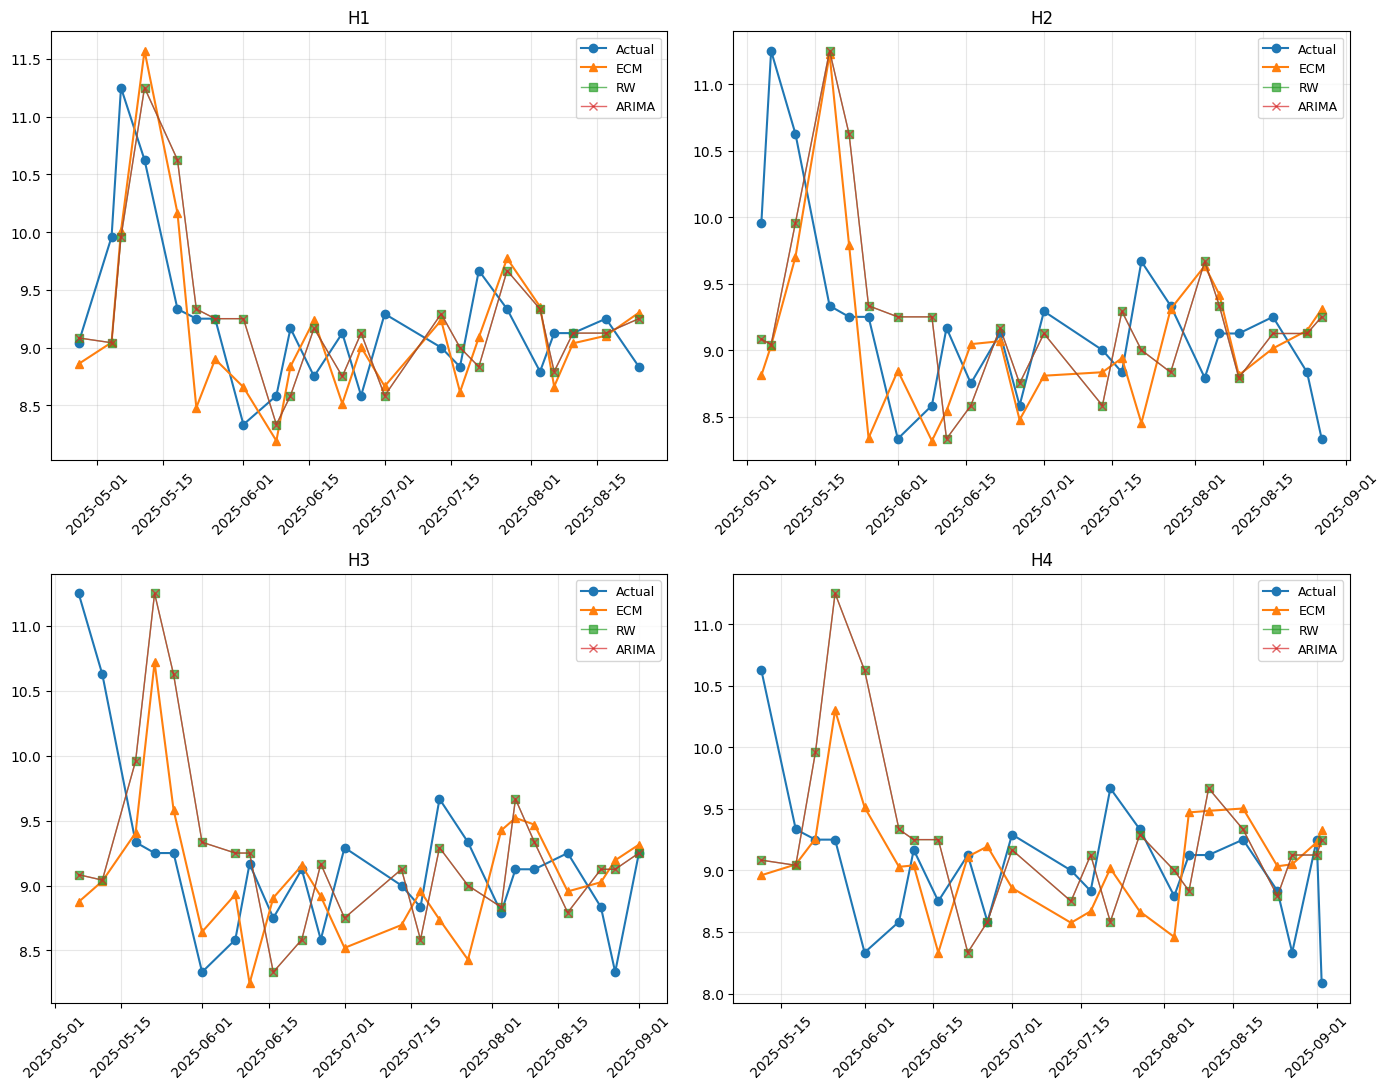


🔍 Actual vs Predicted (scatter) per horizon — ECM


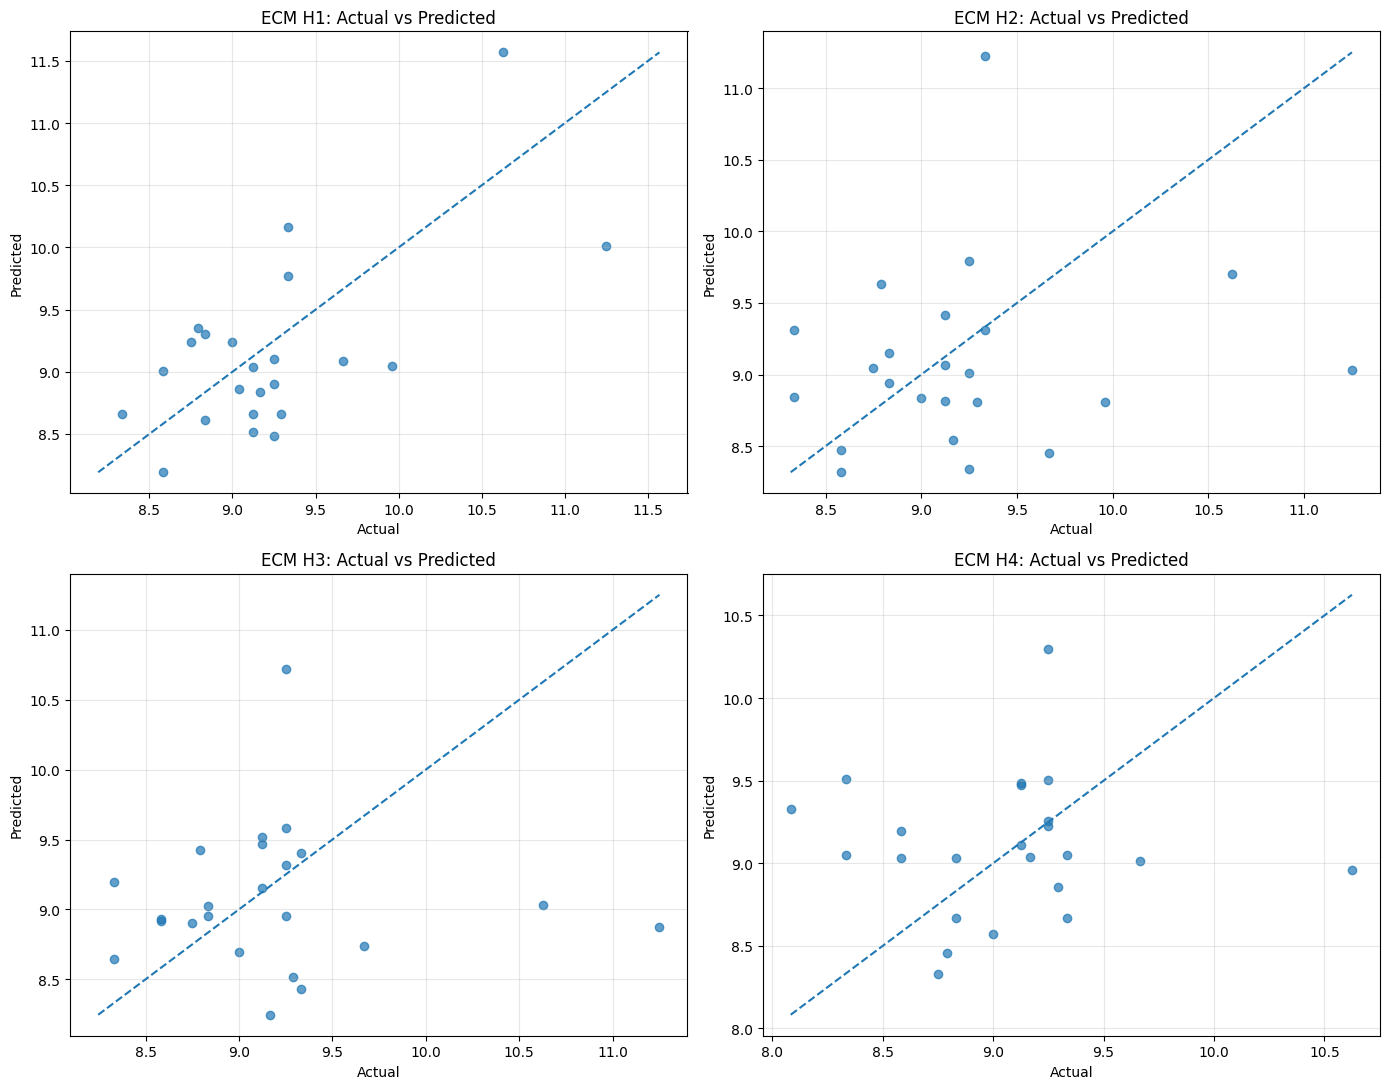


🔬 Residual diagnostics (ECM final model)


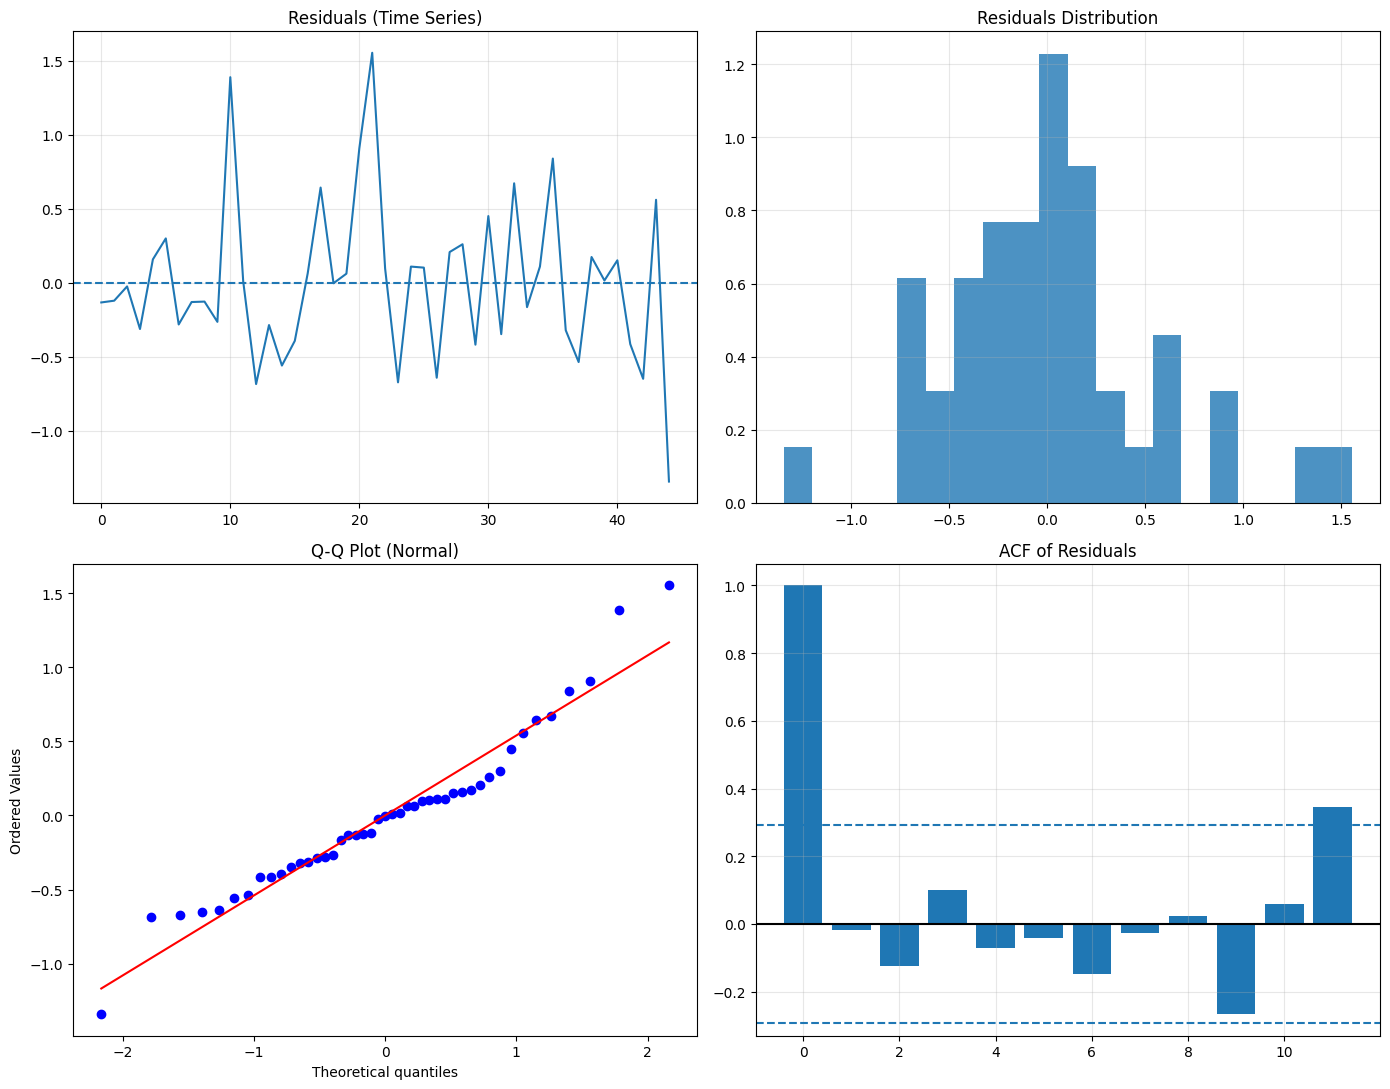


✅ VISUALS COMPLETE


In [559]:
# 1) Console summary
_ = _display_results(cointegration_results, ecm_results, eval_out)

# 2) Inline plots
_display_plots(aligned_data, cointegration_results, ecm_results, eval_out)


In [560]:
from line1_implied.run_all import run_pipeline_complete